In [1]:
import xarray as xr
import pandas as pd
import dask.dataframe as dd
import hvplot.pandas  # noqa
import hvplot.dask  # noqa
import numpy as np
import datetime
from scipy import stats
import matplotlib.dates as dates

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from dask.distributed import Client

client = Client("tcp://10.0.132.56:43065")
client

<Client: 'tcp://10.0.132.56:43065' processes=4 threads=4, memory=5.00 GB>

# Build Dask Cluster
1. Use gui interface to create a new cluster with ~10 workers
2. Use < > to insert an "import Client" statement. This is critical because it is how your script knows to use yoru cluster. 
3. Execute client cell
4. Execute your Dask Cell. Note that once you have a cluster running you do not need to re-import the client. 
5. When finished, always shut down your cluster. 

## Read in Eastern Caldera

In [4]:
# ds =xr.open_dataset('/home/jovyan/data/botpt/RS03ECAL-MJ03E-06-BOTPTA302/deployment0001_RS03ECAL-MJ03E-06-BOTPTA302-streamed-botpt_nano_sample_20191012T060000-20191014T235959.950000_resampled.nc')
# ds

In [5]:
ds1 = xr.open_mfdataset('/home/jovyan/data/botpt/RS03CCAL-MJ03E-06-BOTPTA302/*_resampled.nc', parallel=True).chunk(10080)
ds1['bottom_pressure_eastern'] = ds1['bottom_pressure']
del ds1['bottom_pressure']
ds1

<xarray.Dataset>
Dimensions:                  (index: 2581724)
Coordinates:
  * index                    (index) datetime64[ns] 2014-09-04 ... 2019-10-14T23:59:00
Data variables:
    bottom_pressure_eastern  (index) float32 dask.array<chunksize=(10080,), meta=np.ndarray>

## Read in Central Caldera

In [6]:
# ds =xr.open_dataset('/home/jovyan/data/botpt/RS03CCAL-MJ03F-05-BOTPTA301/deployment0001_RS03CCAL-MJ03F-05-BOTPTA301-streamed-botpt_nano_sample_20140904T000000-20141128T115959.950000_resampled.nc')
# ds

In [7]:
ds2 = xr.open_mfdataset('/home/jovyan/data/botpt/RS03CCAL-MJ03F-05-BOTPTA301/*_resampled.nc', parallel=True).chunk(10080)
ds2['bottom_pressure_central'] = ds2['bottom_pressure']
del ds2['bottom_pressure']
ds2

<xarray.Dataset>
Dimensions:                  (index: 2606374)
Coordinates:
  * index                    (index) datetime64[ns] 2014-09-04 ... 2019-10-14T23:59:00
Data variables:
    bottom_pressure_central  (index) float32 dask.array<chunksize=(10080,), meta=np.ndarray>

## Create DataFrame

In [8]:
#df = ds1.to_dask_dataframe()
df1 = ds1.to_dataframe()
df2= ds2.to_dataframe()
del ds1
del ds2

In [9]:
df1['Datetime']=np.datetime_as_string(df1.index)
df2['Datetime']=np.datetime_as_string(df2.index)

In [10]:
df1['Datetime']=df1['Datetime'].str[:19]
df2['Datetime']=df2['Datetime'].str[:19]

In [11]:
df_botpt=pd.merge(df1,df2, on = 'Datetime')
del df1
del df2
df_botpt.tail()

bottom_pressure_eastern             Datetime  bottom_pressure_central
2576362              2240.960938  2019-10-14T23:55:00              2254.007324
2576363              2240.949463  2019-10-14T23:56:00              2253.995605
2576364              2240.938232  2019-10-14T23:57:00              2253.984375
2576365              2240.925781  2019-10-14T23:58:00              2253.970215
2576366              2240.910156  2019-10-14T23:59:00              2253.955811

## trimming data frame

In [12]:
df_botpt= df_botpt.set_index(pd.to_datetime(df_botpt['Datetime']))
#del df_botpt['Datetime']
df_botpt['depthDiff']= df_botpt['bottom_pressure_eastern'] - df_botpt['bottom_pressure_central']
df_botpt =df_botpt.loc['2015-05-01 00:00:00':'2019-10-14 00:00:00']
df_botpt['spikes']=(df_botpt['depthDiff'] - df_botpt['depthDiff'].rolling(1000).median()).abs() < 0.1
df_botpt['cleanDiff']=df_botpt['depthDiff'].where(df_botpt.spikes)
#df_botpt['bottom_pressure_eastern']= df_botpt.bottom_pressure_eastern.round(3)
#df_botpt['bottom_pressure_central']= df_botpt.bottom_pressure_central.round(3)
#df_botpt.sample(100)
df_botpt.head()

bottom_pressure_eastern             Datetime  \
Datetime                                                            
2015-05-01 00:00:00              2241.314697  2015-05-01T00:00:00   
2015-05-01 00:01:00              2241.314941  2015-05-01T00:01:00   
2015-05-01 00:02:00              2241.314209  2015-05-01T00:02:00   
2015-05-01 00:03:00              2241.310303  2015-05-01T00:03:00   
2015-05-01 00:04:00              2241.307129  2015-05-01T00:04:00   

                     bottom_pressure_central  depthDiff  spikes  cleanDiff  
Datetime                                                                    
2015-05-01 00:00:00              2256.084717 -14.770020   False        NaN  
2015-05-01 00:01:00              2256.085938 -14.770996   False        NaN  
2015-05-01 00:02:00              2256.085938 -14.771729   False        NaN  
2015-05-01 00:03:00              2256.081543 -14.771240   False        NaN  
2015-05-01 00:04:00              2256.079834 -14.772705   False        NaN

In [13]:
df_botpt['bottom_pressure_eastern'].hvplot(datashade=True)

:DynamicMap   []
   :RGB   [Datetime,bottom_pressure_eastern]   (R,G,B,A)

In [14]:
df_botpt['bottom_pressure_central'].hvplot(datashade=True)

:DynamicMap   []
   :RGB   [Datetime,bottom_pressure_central]   (R,G,B,A)

In [15]:
df_botpt['depthDiff'].hvplot(datashade=True)

:DynamicMap   []
   :RGB   [Datetime,depthDiff]   (R,G,B,A)

In [16]:
height = df_botpt['depthDiff'].tolist()
time_int = []
time = list(pd.to_datetime(df_botpt.index.values))
for i in time:
    i = np.datetime64(i).astype(datetime.datetime)
    time_int.append(dates.date2num(i))

In [17]:
df_botpt['date']=pd.DatetimeIndex(df_botpt.index).date

In [18]:
df_botptMean=df_botpt.groupby('date').mean()
df_botptMean.head()

bottom_pressure_eastern  bottom_pressure_central  depthDiff  \
date                                                                      
2015-05-01              2242.323730              2257.087158 -14.763514   
2015-05-02              2242.330078              2257.091553 -14.761411   
2015-05-03              2242.337402              2257.100586 -14.763177   
2015-05-04              2242.327393              2257.088623 -14.761164   
2015-05-05              2242.318604              2257.082520 -14.763873   

             spikes  cleanDiff  
date                            
2015-05-01  0.30625 -14.762942  
2015-05-02  1.00000 -14.761411  
2015-05-03  1.00000 -14.763177  
2015-05-04  1.00000 -14.761164  
2015-05-05  1.00000 -14.763873

### Load in seismic data

In [19]:
seismic_file = '/home/jovyan/data/botpt/axial_seismic/hypo71_11_2019.txt'
df_seismic = pd.read_csv(seismic_file, delim_whitespace=True, dtype=object)
df_seismic['datetime'] = df_seismic['yyyymmdd'] + 'T' + \
            df_seismic['HHMM'].str.slice(start=0, stop=2) + ':' + \
            df_seismic['HHMM'].str.slice(start=2) 
df_seismic.index = pd.to_datetime(df_seismic['datetime'].values)
df_seismic['datetime'] = pd.to_datetime(df_seismic['datetime'].values)
df_seismic = df_seismic.loc['2015-05-01 00:00:00':'2019-10-14 00:00:00']
df_seismic.datetime.astype(np.int64).values/1e64
df_seismic['date'] =pd.DatetimeIndex(df_seismic.datetime).date
df_seismic['Depth']= df_seismic['Depth'].astype(np.float).values
df_seismic['MW']= df_seismic['MW'].astype(np.float).values
df_seismic['RMS']= df_seismic['RMS'].astype(np.float).values
del df_seismic['NWR']
del df_seismic['GAP']
del df_seismic['DMIN']
del df_seismic['ERH']
del df_seismic['ERZ']
del df_seismic['ID']
del df_seismic['PMom']
del df_seismic['SMom']
del df_seismic['yyyymmdd']
del df_seismic['HHMM']
del df_seismic['SSS.SS']
del df_seismic['Lat(D']
del df_seismic['M)']
del df_seismic['Lon(D']
del df_seismic['M).1']
df_seismic.head()

Depth    MW   RMS            datetime        date
2015-05-01 00:02:00   1.91  0.48  0.03 2015-05-01 00:02:00  2015-05-01
2015-05-01 00:27:00   0.82  0.03  0.01 2015-05-01 00:27:00  2015-05-01
2015-05-01 00:28:00   0.43 -0.23  0.01 2015-05-01 00:28:00  2015-05-01
2015-05-01 00:44:00   0.71 -0.16  0.01 2015-05-01 00:44:00  2015-05-01
2015-05-01 00:46:00   0.44 -0.34  0.04 2015-05-01 00:46:00  2015-05-01

## Create new dataframe with count per day

In [20]:
df_eqMean=df_seismic.groupby('date').mean()
df_eqCount= df_seismic.groupby('date').count()
df_eqCount['count'] = df_eqCount.datetime.astype('float64').values
df_eqMean['count'] = df_eqCount['count'].values
df_eqMean.head()

Depth        MW       RMS  count
date                                           
2015-05-01  1.194603  0.196984  0.045397   63.0
2015-05-02  1.246190  0.240714  0.049524   42.0
2015-05-03  0.995306  0.165510  0.040000   49.0
2015-05-04  1.247429  0.177143  0.047714   35.0
2015-05-05  1.202955  0.201364  0.057273   44.0

In [23]:
cumsum_eq = np.cumsum(df_eqMean)

### Merge botpt and EQ Magnitude

In [26]:
df_plot = pd.merge(df_botptMean, df_eqMean, on = 'date')
del df_plot['bottom_pressure_eastern']
del df_plot['bottom_pressure_central']
del df_plot['spikes']
del df_plot['cleanDiff']
del df_plot['Depth']
del df_plot['RMS']
del df_plot['count']
# df_botpt=pd.merge(df1,df2, on = 'Datetime')

In [27]:
df_plot.head()

depthDiff        MW
date                           
2015-05-01 -14.763514  0.196984
2015-05-02 -14.761411  0.240714
2015-05-03 -14.763177  0.165510
2015-05-04 -14.761164  0.177143
2015-05-05 -14.763873  0.201364

In [28]:
df_plot.hvplot()

:NdOverlay   [Variable]
   :Curve   [date]   (value)

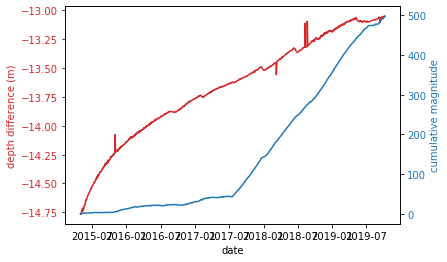

In [31]:
import matplotlib.pyplot as plt 
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('depth difference (m)', color=color)
ax1.plot(df_plot['depthDiff'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('cumulative magnitude', color=color)  # we already handled the x-label with ax1
ax2.plot(df_plot['mw_cumsum'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# host.axis["bottom"].major_ticklabels.set_rotation(30)
plt.show()